# RL for inverted pendulum controlled with muscle

In [1]:
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt

import sys
sys.path.append("../../Biodiffrl")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90"

# Optionally, force JAX to preallocate memory.
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Setup environment variable for Nvidia GPU acceleration
os.environ['XLA_FLAGS'] = (
    "--xla_gpu_triton_gemm_any=true"
    # '--xla_gpu_enable_async_collectives=true '
    # '--xla_gpu_enable_latency_hiding_scheduler=true '
    # '--xla_gpu_enable_highest_priority_async_stream=true '
    # '--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=32'
)

backend = 'gpu'
# backend = 'METAL'
# backend = 'cpu'

import jax
jax.config.update('jax_platform_name', 'gpu')
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_lazy_compilation=false"
# Enable compliation catch
os.environ["JAX_COMPILATION_CACHE_DIR"] = "./jax_cache"
jax.config.update("jax_compilation_cache_dir", "./jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", 0)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 2)
# jax.config.update("jax_explain_cache_misses", True)

# Solve NaN on newer nvidia cards
jax.config.update('jax_default_matmul_precision', "high")

from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./jax_cache")
# Debug Nan
# jax.config.update("jax_debug_nans", True)

from jax import numpy as jp
# More legible printing from numpy.
jp.set_printoptions(precision=4, suppress=True, linewidth=100)

import mujoco
import mujoco.mjx as mjx
from mujoco.mjx._src import scan
from mujoco.mjx._src import types

# More legible printing from numpy.
np.set_printoptions(precision=4, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

device = jax.devices(backend=backend)[0]

model_path = '/home/bugman/Currentwork/biomujoco_rl/RL/simple_example/inverted_pendulum_mtu.xml'
# model_path = '/home/bugman/Currentwork/biomujoco_converter/converted/mjc/Gait2354/gait2354_cvt1_easy.xml'
# model_path = "/home/bugman/Downloads/Genesis-main/genesis/assets/xml/franka_emika_panda/panda.xml"

# Single step
mjx_step = jax.jit(mjx.step, backend=backend)

In [2]:
from mujoco.mjx._src.biomtu import acceleration_mtu

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
# opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
# mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Load the Keyframe
# mjx_data = mjx_data.replace(qpos = mj_model.key_qpos[0])
# mj_data.qpos = mj_model.key_qpos[0]

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)
mjx_data = jax.jit(mjx_step)(mjx_model, mjx_data)

init_mjx_data = mjx_data

def print_all():
    print(mjx_model.biomtu_adr)
    print(mjx_model.mtu_wrap_objid)
    print(mjx_model.mtu_wrap_type)
    print(mjx_model.biomtu_fiso)
    print(mjx_model.biomtu_vmax)
    print(mjx_model.biomtu_ofl)
    print(mjx_model.biomtu_opa)
    print(mjx_model.biomtu_mass)
    print("-------Data--------")
    print("qpos:", mjx_data.qpos)
    print("mtu l:", mjx_data.biomtu.l)
    print("tendon l:", mjx_data.biomtu.tendon_l)
    print("fiber l :", mjx_data.biomtu.fiber_l)
    print("Muscle Bce:", mjx_data.biomtu.B_ce)
    print("Muscle vm:", mjx_data.biomtu.m)
    print("Fiber acc:", mjx_data.biomtu.fiber_acc)
    print("Fiber v:", mjx_data.biomtu.fiber_v)
    print("Biomtu h:", mjx_data.biomtu.h)
    print(mjx_data.biomtu.v)
    print(mjx_data.biomtu.h)  # The constant high of the muscle.
    print(mjx_data.biomtu.pennation_angle)
    print(mjx_data.biomtu.origin_body_id)
    print(mjx_data.biomtu.insertion_body_id)
    print("mtu act:", mjx_data.biomtu.act)
    # print(mjx_data.biomtu.j)
    print(mjx_data.qfrc_biomtu)
    # print(mj_model.key_time)
    # print(mj_model.key_qpos)
    # print(mj_model.key_qvel)

print_all()

# print(mjx_model.nbiomtu)
# print(mjx_model.nq)
# print(mjx_data.qpos)
# print(mjx_data.qvel)

[0 2]
[0 2 1 3]
[3 3 3 3]
[1000. 1000.]
[10. 10.]
[0.3 0.3]
[0.0524 0.0524]
[1. 1.]
-------Data--------
qpos: [-0.  0.]
mtu l: [0.7 0.7]
tendon l: [0.3046 0.3046]
fiber l : [0.3957 0.3957]
Muscle Bce: [0.05 0.05]
Muscle vm: [0.3333 0.3333]
Fiber acc: [0.0102 0.0102]
Fiber v: [0. 0.]
Biomtu h: [0.0157 0.0157]
[0. 0.]
[0.0157 0.0157]
[0.0397 0.0397]
[0 0]
[1 1]
mtu act: [0. 0.]
[0. 0.]


In [3]:
import exp

# Multiple steps
def step_fn(carry, _):
    model, data= carry
    new_data = mjx.step(model, data)
    new_carry = (model, new_data)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (model, data)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[1]
    return new_data



jit_multiple_steps = jax.jit(multiple_steps)

In [ ]:
import mujoco.viewer
import time

# Debug Nan
# jax.config.update("jax_debug_nans", True)

mj_model = mujoco.MjModel.from_xml_path(model_path)
mjx_model = mjx.put_model(mj_model,device=device)

# Disable tendon
# opt = mjx_model.opt.replace(disableflags = mjx_model.opt.disableflags |mujoco.mjtDisableBit.mjDSBL_PASSIVE)
# mjx_model = mjx_model.replace(opt=opt)

mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)

# Calculate equilibrum
mjx_data = acceleration_mtu.calc_equilibrium(mjx_model, mjx_data)

previous_frame_time = time.time()
i = 0
# key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied*10, dtype=jp.float32))
        
        # Generate key
        # key = jax.random.split(key,1)[0]
        # xfrc = jax.random.uniform(key,(mjx_model.nbody, 6), minval=-10, maxval=10)
        # mjx_data = mjx_data.replace(xfrc_applied=xfrc)
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        
        # Control Muscle
        mjx_data = mjx_data.replace(biomtu = mjx_data.biomtu.replace(act = jp.array([0.1,0.1])))
        
        # mjx_data = mjx_step(mjx_model, mjx_data)
        mjx_data = jit_multiple_steps(mjx_model, mjx_data)
        # mjx_data, loss, exps = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        # mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        # print("ACT:", mjx_data.biomtu.act)
        print(mjx_data.qpos)
        # print(mj_data.sen)  
        # print(mjx_data.sensordata[3:6])
        # print(mjx_data.biomtu.act)
        # print(mjx_data.qfrc_inverse[6], mjx_data.qfrc_inverse[15] )
        # print(mjx_data.qfrc_constraint[6], mjx_data.qfrc_constraint[15])
        # print(len(mjx_data.qvel))
        
        
        viewer.sync()

## Neural Network

In [3]:
import nn

key = jax.random.key(6848)
# Controller NN
controller_nn = nn.Controller_NN(mjx_model.nq*2+mjx_model.nbiomtu*2, 2)     # There are two muscle so two output
controller_params, key = controller_nn.init_parameters(key)
controller = controller_nn.get_fn()

# Critic NN
critic_nn = nn.Critic_NN(mjx_model.nq*2 + mjx_model.nbiomtu*2 ,1)
critic_params, key = critic_nn.init_parameters(key)
criticer = critic_nn.get_fn()

# Test the two neural networks
print(controller(controller_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2), key))
print(criticer(critic_params, jp.ones(mjx_model.nq*2+mjx_model.nbiomtu*2)))

(Array([0.2092, 0.2158], dtype=float32), Array([0.209 , 0.2155], dtype=float32), Array([-0.4978, -0.1023], dtype=float32))
[-1.485]


In [4]:
from functools import partial
# Since the environment resets with init_mjx_data, the muscles are already in the equilibrum condition.
def reset(init_mjx_data, batch_size):
    new_data = jax.tree.map(
        partial(jp.repeat, repeats=batch_size, axis=0),
        jax.tree.map(partial(jp.expand_dims, axis=0),init_mjx_data))
    return new_data

def random_init(data, model, rng: jax.Array):
    nbiomtu = model.nq
    init_qpos = data.qpos
    init_qvel = data.qvel
    new_rng, rng1, rng2 = jax.random.split(rng, 3)
    # Qpos_1 is the vertical position
    random_qpos = init_qpos + jax.random.uniform(rng1, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    random_qvel = init_qvel + jax.random.uniform(rng2, [nbiomtu], minval=jp.array(-1.0, dtype=jp.float32), maxval=jp.array(1.0, dtype=jp.float32))*0.01
    newdata = data.replace(qpos=random_qpos)
    newdata = newdata.replace(qvel=random_qvel)
    newdata = mjx.forward(mjx_model, newdata)
    # print('data:',data.qpos, data.qvel)
    # Calculate equilibrum
    # newdata = acceleration_mtu.calc_equilibrium(mjx_model, newdata)
    # newdata = mjx_step(mjx_model, newdata)
    return newdata, new_rng

vrandom_init = jax.jit(jax.vmap(random_init, in_axes=(None, None, 0), out_axes=0))

In [5]:
import exp

def step_fn(carry, _):
    data, model = carry
    new_data = mjx.step(model, data)
    new_carry = (new_data, model)
    return new_carry, _

def multiple_steps(model, data):
    init_carry = (data, model)
    y, _ = jax.lax.scan(step_fn, init_carry, None, length=10)
    new_data = y[0]
    return new_data

def nn_mjx_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, act

def nn_mjx_perturbe_one_step(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    xfrc = jax.random.normal(key,(mjx_model.nbody, 6))*1.0
    data = data.replace(xfrc_applied=xfrc)
    new_data = mjx.step(model, data)
    return new_data, new_key, act


@jax.jit
def jit_nn_mjx_one_step_no_random(nn_params, model, data, key):
    states = jp.concatenate([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    act, mean, std = controller(nn_params, states, key)
    # Generate the next key
    new_key = jax.random.split(key,1)[0]
    data = data.replace(biomtu = data.biomtu.replace(act = act))
    new_data = mjx.step(model, data)
    return new_data, new_key, mean

def nn_step_fn(carry, _):
    nn_params, model, data, key = carry
    new_data, new_key, act = nn_mjx_one_step(nn_params, model, data, key)
    # new_data, new_key, act = nn_mjx_perturbe_one_step(nn_params, model, data, key)
    new_carry = (nn_params, model, new_data, new_key)
    # Calculate reward
    states = jp.concat([data.qpos, data.qvel, data.biomtu.fiber_l, data.biomtu.fiber_v])
    next_states = jp.concat([new_data.qpos, new_data.qvel, new_data.biomtu.fiber_l, new_data.biomtu.fiber_v])
    action = act
    reward = -data.qpos[1]**2
    done = jp.abs(data.qpos[1])>0.8
    experience = exp.experience(states, next_states, action, reward, done)
    
    return new_carry, experience

def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

@jax.jit
def jit_nn_multi_steps(nn_params, model, data, key):
    # Also deal with the done in the experience pool
    
    repeat_length = 32
    init_carry = (nn_params, model, data, key)
    y, experience = jax.lax.scan(nn_step_fn, init_carry, None, length=repeat_length)
    new_data = y[2]
    new_key = y[3]
    
    return new_data, new_key, experience

# @jax.jit
def v_nn_multi_steps(nn_params, model, data, keys):
    return jax.vmap(jit_nn_multi_steps, in_axes=(None, None, 0, 0))(nn_params, model, data, keys)

jit_v_nn_multi_steps = jax.jit(v_nn_multi_steps)

# This function generate
@jax.jit
def jit_vv_nn_multi_steps(nn_params, model, data, key):
    return jax.vmap(jit_v_nn_multi_steps, in_axes=(None, None, None, 1))(nn_params, model, data, key)

In [36]:
# Settings
import exp

critic_batch_size =5000
controller_batch_size = 1000
key = jax.random.key(2024)
keys = jax.random.split(key, controller_batch_size)

memory_settings = exp.memory_settings(critic_batch_size*5, mjx_model.nq*2+mjx_model.nbiomtu*2, mjx_model.nbiomtu, 1)

In [7]:
exp_pool = None
datas = jax.jit(reset,static_argnames="batch_size")(init_mjx_data, controller_batch_size)
init_data_batch = datas
for i in range(20):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)
    
print(exp_pool.states.shape)

(50000, 8)


In [8]:
import optax

v_criticer = jax.vmap(criticer,in_axes=(None, 0))
jit_v_criticer = jax.jit(v_criticer)

def critic_loss(params, batch):
    discount = 0.99
    states = batch.states
    next_states = batch.next_states
    actions = batch.actions
    rewards = batch.rewards
    
    critic_score = v_criticer(params, states)
    target = rewards + discount* jax.lax.stop_gradient(v_criticer(params, next_states))
    # target = rewards + discount* (v_criticer(params, next_states))
    
    loss = optax.l2_loss(critic_score, target)
    loss = jp.mean(loss)
    return loss

sample_batch = exp.memory.sample(exp_pool, critic_batch_size, key)
critic_loss_g_value_lower= jax.jit(jax.value_and_grad(critic_loss)).lower(critic_params, sample_batch)

jit_critic_loss_g_value = critic_loss_g_value_lower.compile()
a=jit_critic_loss_g_value.cost_analysis()[0]['flops']
print(a)

721252864.0


In [9]:
def decay_sum_scan(x, decay):
    def f(sxtm1, xt):
        b = xt + decay * sxtm1
        return b, b
    return jax.lax.scan(f, jp.zeros(x.shape[1:]), x)[1]

def controller_loss_and_experience(controller_params, critic_params, batch, batch_size, mjx_model, init_data_batch, keys):
    # Generate data for simulation
    nq = mjx_model.nq
    nmtu = mjx_model.nbiomtu
    
    # Deal with the done state, reset the done state with init state
    # exp_data_batch = init_data_batch.replace(
    #     qpos = batch.states[:,0:nq], 
    #     qvel = batch.states[:,nq:nq*2],
    #     biomtu = init_data_batch.biomtu.replace(
    #         fiber_l = batch.states[nq*2, nq*2+nmtu],
    #         fiber_v = batch.states[nq*2+nmtu, nq*2+nmtu*2]
    #     ))
    
    qpos = jp.where(batch.dones==1, init_data_batch.qpos, batch.states[:,0:nq])
    qvel = jp.where(batch.dones==1, init_data_batch.qvel, batch.states[:,nq:nq*2])
    fiber_l = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_l, batch.states[:,nq*2 : nq*2+nmtu])
    fiber_v = jp.where(batch.dones==1, init_data_batch.biomtu.fiber_v, batch.states[:,nq*2+nmtu : nq*2+nmtu*2])
    
    # in_data = batch.dones, init_data_batch, exp_data_batch)
    
    in_data = jax.lax.stop_gradient(init_data_batch.replace(
        qpos = qpos,
        qvel = qvel,
        biomtu = init_data_batch.biomtu.replace(
            fiber_l = fiber_l,
            fiber_v = fiber_v)
        )
    )
    
    out_data, keys, new_exps = v_nn_multi_steps(controller_params, mjx_model, in_data, keys)
    # out_states = new_exps.next_states
    # jax.debug.print("out_states shape{0}", out_states.shape)
    out_states = jp.concat([out_data.qpos, out_data.qvel, out_data.biomtu.fiber_l, out_data.biomtu.fiber_v, out_data.sensordata],axis=1)
    critic_score = jp.squeeze(v_criticer(critic_params, out_states))
    decay_M = 0.99 ** jp.arange(new_exps.rewards.shape[1]-1)
    # print(new_exps.rewards.shape)
    loss = -jp.mean(decay_M@new_exps.rewards.T[:-1,:])
    # loss = -jp.mean(decay_M@new_exps.rewards.T[:-1,:]) - jp.mean(critic_score)
    # loss = -jp.mean(critic_score)
    return loss, new_exps

# The function calculating the loss of the controller and also generate experiences
g_loss_experience = jax.value_and_grad(controller_loss_and_experience, has_aux=True)

controller_keys = jax.random.split(key, controller_batch_size)
sample_batch = exp.memory.sample(exp_pool, controller_batch_size, key)

print("lowering")
g_loss_experience_lower = jax.jit(g_loss_experience, static_argnames=["batch_size"]).lower(
    controller_params, 
    critic_params, 
    sample_batch, 
    controller_batch_size, 
    mjx_model, 
    init_data_batch, 
    controller_keys)

print("compiling")
jit_g_loss_experience = g_loss_experience_lower.compile()

b = jit_g_loss_experience.cost_analysis()[0]['flops']
print(b)

lowering
compiling
232385856.0


In [10]:
print(sample_batch.states.shape)

b/a

(1000, 8)


0.32219748107648416

## Train the two Neural Networks

In [46]:

key = jax.random.key(24)

critic_params, key = critic_nn.init_parameters(key)
critic_tx = optax.apply_if_finite(optax.adam(learning_rate=1e-5), max_consecutive_errors=10)
# critic_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
critic_opt_state = critic_tx.init(critic_params)
jit_critic_tx_update = jax.jit(critic_tx.update)


controller_params, key = controller_nn.init_parameters(key)
controller_tx = optax.apply_if_finite(optax.adam(learning_rate=2-6), max_consecutive_errors=50)
# controller_tx = optax.apply_if_finite(optax.sgd(learning_rate=1e-5), max_consecutive_errors=50)
controller_opt_state = controller_tx.init(controller_params)
jit_controller_tx_update = jax.jit(controller_tx.update)

jit_apply_update = jax.jit(optax.apply_updates)


jit_sample = jax.jit(exp.memory.sample, static_argnames="batch_size")
jit_add_exp = jax.jit(exp.memory.add_exp, static_argnames="settings")

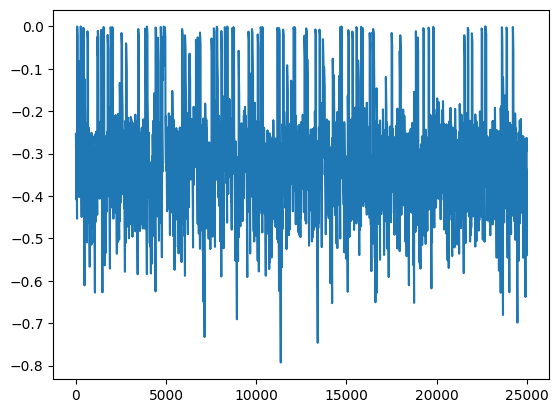

In [47]:
# Init exp_pool
exp_pool = None
datas = reset(init_mjx_data, controller_batch_size)
keys = jax.random.split(key, controller_batch_size)
# datas = reset(init_mjx_data, 2)
# keys = jax.random.split(key, 2)
for i in range(15):
    datas, keys, exps = jit_v_nn_multi_steps(controller_params, mjx_model, datas, keys)
    # print(datas.qvel.shape, datas.ten_J.shape)
    if(i>=5):
        exp_pool = exp.memory.add_exp(memory_settings, exp_pool, exps)

#plot exp_pool
# plt.plot(exp_pool.states.T[1])
plt.plot(exp_pool.rewards)
# plt.plot(exp_pool.states[0])

---------- 0 ----------
criticer loss: 0.05143042
Controller Loss: 10.326528
mean rewards: -0.3938833
mean score: -1.0209383
scorc/reward: 2.5919816
death rate: 0.05590625
---------- 1 ----------
criticer loss: 0.08791477
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(controller_loss_and_experience)

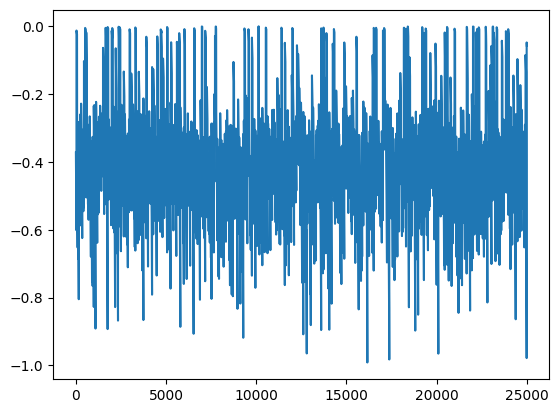

In [48]:
jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_debug_nans", False)
import exp


death_rate_buf = []
best_death_rate = 0.5

for i in range(4000):

    print("----------",i,"----------")
    criric_repeat = 1
    if(i >= 200):
        criric_repeat = 1
        
    for j in range(criric_repeat):
        batch = jit_sample(exp_pool, critic_batch_size, key)
        key = jax.random.split(key, 1)[0]
        
        # criticer
        critic_loss, critic_loss_grad = jit_critic_loss_g_value(critic_params, batch)
        
        # Update params
        critic_updates, critic_opt_state = jit_critic_tx_update(critic_loss_grad, critic_opt_state)
        critic_params = jit_apply_update(critic_params, critic_updates)
    
    print("criticer loss:",critic_loss)
    # controller
    
    controller_repeat = 1
    # if(i >= 10):
        # controller_repeat = 5
    
    for j in range(controller_repeat):
        keys = jax.random.split(key,controller_batch_size)
        controller_batch = jit_sample(exp_pool, controller_batch_size, key)
        key = jax.random.split(key, 1)[0]
        controller_loss_exps, controller_loss_grad = jit_g_loss_experience(
            controller_params, critic_params, controller_batch, mjx_model, init_data_batch, keys)
        controller_loss = controller_loss_exps[0]
        exps = controller_loss_exps[1]
            
        # Update params
        controller_updates, controller_opt_state = jit_controller_tx_update(controller_loss_grad, controller_opt_state)
        controller_params = jit_apply_update(controller_params, controller_updates)
    
    exp_pool = jit_add_exp(memory_settings, exp_pool, exps)
    
    # Count Dones
    death_rate_buf.insert(0, jp.count_nonzero( exps.dones)/(exps.dones.shape[1]*controller_batch_size))
    death_rate_buf = death_rate_buf[:50]
    death_rate = np.mean(death_rate_buf)
    
    print("Controller Loss:", controller_loss)
    mean_reward = jp.mean(exps.rewards)
    print("mean rewards:", mean_reward)
    mean_score = jp.mean(jit_v_criticer(critic_params, exps.states))
    print("mean score:", mean_score)
    print("scorc/reward:", mean_score/mean_reward)
    print("death rate:", death_rate)
    # print(controller_loss_grad)
    
    if(best_death_rate > death_rate): best_death_rate = death_rate
    # print("best_death_rate:", best_death_rate)
    # add exps
    
    if(i%20 == 0):
        plt.figure()
        plt.plot(exp_pool.rewards)
        plt.plot()
        # plt.plot(exp_pool.rewards)

In [ ]:
print(ex)

In [ ]:
import mujoco.viewer
import time


mjx_data = mjx.make_data(mjx_model)
mj_data = mujoco.MjData(mj_model)
previous_frame_time = time.time()
i = 0
key = jax.random.key(334)
with mujoco.viewer.launch_passive(mj_model, mj_data) as viewer:
    while viewer.is_running():
        # Update mjx_data from mj_data. The mj_data was modified by the viewer
        # mjx_data = mjx_data.replace(ctrl=mj_data.ctrl, xfrc_applied=mj_data.xfrc_applied)
        # Use the nerual network to generate ctrl signal
        # Generate key
        mjx_data = mjx_data.replace(xfrc_applied=jp.array(mj_data.xfrc_applied, dtype=jp.float32))
        mjx_data = mjx_data.replace(
            qpos= jp.array(mj_data.qpos, dtype=jp.float32),
            qvel= jp.array(mj_data.qvel, dtype=jp.float32),
            time = jp.array(mj_data.time, dtype=jp.float32))
        
        # Update mjx_model from mj_model
        mjx_model = mjx_model.tree_replace({
            'opt.gravity': jp.array(mj_model.opt.gravity, dtype=jp.float32),
            'opt.tolerance': jp.array(mj_model.opt.tolerance, dtype=jp.float32),
            'opt.ls_tolerance': jp.array(mj_model.opt.ls_tolerance, dtype=jp.float32),
            'opt.timestep': jp.array(mj_model.opt.timestep, dtype=jp.float32),
        })
        
        key = jax.random.split(key,1)[0]
        # mjx_data = mjx_step(mjx_model, mjx_data)
        # mjx_data, loss, expp = jit_nn_multi_steps(controller_params, mjx_model, mjx_data, key)
        mjx_data, key, act = jit_nn_mjx_one_step_no_random(controller_params, mjx_model, mjx_data, key)
        mjx.get_data_into(mj_data, mj_model, mjx_data)
        
        # Record the current time at the start of this frame
        current_frame_time = time.time()
    
        # Calculate the difference in time from the last frame
        time_between_frames = current_frame_time - previous_frame_time
    
        # Print the time between frames
        print(f"Time between frames: {time_between_frames} seconds")
        previous_frame_time = current_frame_time
        
        print("ACT:", mjx_data.biomtu.act)
        # print(mjx_data.qpos)
        # print(mjx_data.sensordata)
        # print(len(mjx_data.qvel))
        viewer.sync()